# **HOME CREDIT SCORECARD MODEL**





**PROBLEMS**

> Home Credit Indonesia ingin mengembangkan model machine learning untuk mendukung tim dalam menilai persetujuan atau penolakan pinjaman. Selanjutnya, HCI tertarik untuk menganalisis data nasabah untuk mengidentifikasi profil nasabah yang sering mengajukan pinjaman dan yang berhasil disetujui. Hal ini bertujuan untuk menetapkan target pasar berikutnya dengan lebih akurat.



# **IMPORT LIBRARY**

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Import library yang dibutuhkan
import pandas as pd #Library untuk manipulasi data tabular
import numpy as np #Library untuk operasi numerik
from scipy import stats #Library untuk analisis statistik

import seaborn as sns #Library untuk visualisasi data
import matplotlib.pyplot as plt #Library untuk plotting grafik

from sklearn import preprocessing #Library untuk preprocessing data
from sklearn.model_selection import train_test_split #Library untuk pemisahan data dan validasi silang
from sklearn.linear_model import LogisticRegression #Algoritma Regresi Logistik
import xgboost as xgb #Library untuk algoritma XGBoost
from sklearn.ensemble import RandomForestClassifier #Algoritma Random Forest
from sklearn.tree import DecisionTreeClassifier  #Algoritma Decision Tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay #Library untuk evaluasi hasil klasifikasi
from imblearn.over_sampling import SMOTE #Teknik oversampling SMOTE untuk menangani ketidakseimbangan kelas
from imblearn.under_sampling import RandomUnderSampler #Teknik undersampling Random untuk menangani ketidakseimbangan kelas

# **READ THE DATA (Baca Datanya)**

In [26]:
#Membaca file CSV yang terletak di jalur dan memuatnya ke dalam sebuah DataFrame dengan menggunakan library Pandas
df = pd.read_csv('/content/drive/MyDrive/Home Credit Indonesia/application_train.csv')

In [27]:
df.sample(1)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
234129,371203,0,Revolving loans,F,N,Y,1,90000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# **SEARCH INSIGHT FROM DATA (Cari Wawasan dari Data)**

**Jumlah nasabah yang mengajukan pinjaman**

In [28]:
# Mengelompokkan data berdasarkan 'TARGET' dan menghitung jumlah pelanggan
noc = df.groupby('TARGET')['CODE_GENDER'].count().reset_index()
noc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

# Menghitung persentase jumlah pelanggan terhadap total jumlah pelanggan
noc['Customers_pct'] = round(noc.Customers / noc.Customers.sum(), 2)
noc

,TARGET,Customers,Customers_pct
0,0,282686,0.92
1,1,24825,0.08




> Dari data yang disajikan di atas, terlihat bahwa 92% dari nasabah berhasil melunasi pinjaman dalam jangka waktu tertentu tanpa mengalami kendala, sedangkan 8% mengalami kendala. Oleh karena itu, mari kita telusuri lebih lanjut faktor-faktor apa yang menyebabkan nasabah berhasil melunasi pinjaman tanpa kendala.



# **MARITAL STATUS (Status Pernikahan)**

In [29]:
#Menghitung jumlah kemunculan setiap nilai unik dalam kolom
df.NAME_FAMILY_STATUS.value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64



> Dari tabel tersebut, terdapat enam kategori yang menggambarkan status perkawinan. Kita akan merangkumnya menjadi dua kategori, yaitu "menikah" untuk individu yang memiliki pasangan dan "belum menikah" untuk individu yang belum memiliki pasangan atau sudah memiliki pasangan.



In [30]:
# Membuat list kosong untuk menyimpan status perkawinan
marital_status = []

# List yang berisi status perkawinan yang dianggap sebagai 'Married'
married = ['Married', 'Civil marriage']

# Iterasi melalui setiap nilai dalam kolom 'NAME_FAMILY_STATUS'
for status in df['NAME_FAMILY_STATUS']:
    # Memeriksa apakah nilai status perkawinan termasuk dalam daftar 'married'
    if status in married:
        marital_status.append('Married')
    else:
        marital_status.append('Unmarried')

# Menambahkan kolom baru 'Marital_status' ke dalam dataframe dan mengisinya dengan nilai-nilai yang telah ditentukan sebelumnya
df['Marital_status'] = marital_status

# Menghapus kolom 'NAME_FAMILY_STATUS' dari dataframe
df.drop(columns='NAME_FAMILY_STATUS', inplace=True)

In [31]:
# Menghitung jumlah nasabah berdasarkan status perkawinan ('Marital_status') yang berhasil melunasi pinjaman (TARGET == 0)
ms_acc = df[df['TARGET'] == 0].groupby(['Marital_status'])['CODE_GENDER'].count().reset_index()
ms_acc.rename(columns={'CODE_GENDER': 'Customers'}, inplace=True)

# Menggunakan ms_acc untuk menghitung persentase nasabah dalam setiap kelompok Marital_status
ms_acc['Customers_pct'] = round(noc.Customers / noc.Customers.sum(), 2)

ms_acc

,Marital_status,Customers,Customers_pct
0,Married,208396,0.92
1,Unmarried,74290,0.08




> Dari data diatas menandakan bahwa 74% dari nasabah yang tidak mengalami kesulitan dalam membayar pinjaman adalah mereka yang sudah menikah.



In [32]:
ms_nacc = df[df['TARGET'] == 1].groupby(['Marital_status'])['CODE_GENDER'].count().reset_index()
ms_nacc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms_nacc['Customers_pct'] = round(ms_nacc.Customers / ms_nacc.Customers.sum(), 2)
ms_nacc

,Marital_status,Customers,Customers_pct
0,Married,17811,0.72
1,Unmarried,7014,0.28


In [33]:
# Memfilter dataframe df untuk mendapatkan baris-baris di mana nilai kolom 'Marital_status' sama dengan 'Unmarried'
# Kemudian, melakukan pengelompokkan berdasarkan kolom 'TARGET' dan 'Marital_status',
# dan menghitung jumlah nasabah dalam setiap kelompok dengan menggunakan fungsi count() pada kolom 'CODE_GENDER'
ms = df[df['Marital_status'] == 'Unmarried'].groupby(['TARGET', 'Marital_status'])['CODE_GENDER'].count().reset_index()

# Mengganti nama kolom 'CODE_GENDER' menjadi 'Customers' pada dataframe ms
ms.rename(columns={'CODE_GENDER': 'Customers'}, inplace=True)

# Menghitung persentase jumlah nasabah dalam setiap kelompok 'TARGET' dan 'Marital_status' terhadap total jumlah nasabah yang belum menikah
ms['Customers_pct'] = round(ms.Customers / ms.Customers.sum(), 2)

ms

,TARGET,Marital_status,Customers,Customers_pct
0,0,Unmarried,74290,0.91
1,1,Unmarried,7014,0.09




> Tabel tersebut menyatakan distribusi nasabah berdasarkan status pembayaran pinjaman (TARGET) dan status perkawinan (Marital_status) di mana:
- Terdapat 74,290 nasabah yang belum menikah dan berhasil melunasi pinjaman (TARGET=0), yang menyumbang 91% dari total nasabah yang belum menikah.
- Terdapat 7,014 nasabah yang belum menikah dan mengalami kesulitan dalam melunasi pinjaman (TARGET=1), yang menyumbang 9% dari total nasabah yang belum menikah.



In [34]:
# Memfilter dataframe df untuk mendapatkan baris-baris di mana nilai kolom 'Marital_status' sama dengan 'Married'
# Kemudian, melakukan pengelompokkan berdasarkan kolom 'TARGET' dan 'Marital_status',
# dan menghitung jumlah nasabah dalam setiap kelompok dengan menggunakan fungsi count() pada kolom 'CODE_GENDER'
ms1 = df[df['Marital_status'] == 'Married'].groupby(['TARGET', 'Marital_status'])['CODE_GENDER'].count().reset_index()

# Mengganti nama kolom 'CODE_GENDER' menjadi 'Customers' pada dataframe ms1
ms1.rename(columns={'CODE_GENDER': 'Customers'}, inplace=True)

# Menghitung persentase jumlah nasabah dalam setiap kelompok 'TARGET' dan 'Marital_status' terhadap total jumlah nasabah yang sudah menikah
ms1['Customers_pct'] = round(ms1['Customers'] / ms1['Customers'].sum(), 2)

ms1

,TARGET,Marital_status,Customers,Customers_pct
0,0,Married,208396,0.92
1,1,Married,17811,0.08




> Tabel diatas, menandakan bahwa persentase dari jumlah nasabah dalam setiap kelompok (Customers_pct). Dalam konteks ini, persentase tersebut menunjukkan seberapa besar proporsi nasabah yang termasuk dalam setiap kategori status pembayaran pinjaman (TARGET) dan status perkawinan (Marital_status).



# **CONTRACT TYPE (Jenis Kontrak)**

In [35]:
# Mengelompokkan data dalam dataframe df berdasarkan kolom 'TARGET' dan 'NAME_CONTRACT_TYPE',
# menghitung jumlah nasabah dalam setiap kelompok menggunakan fungsi count() pada kolom 'CODE_GENDER',
# dan mengurutkan hasil pengelompokan berdasarkan 'NAME_CONTRACT_TYPE'
ct = df.groupby(['TARGET', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by='NAME_CONTRACT_TYPE')

# Mengganti nama kolom 'CODE_GENDER' menjadi 'Customers' pada dataframe ct
ct.rename(columns={'CODE_GENDER': 'Customers'}, inplace=True)

# Membuat list yang berisi nama jenis kontrak (NAME_CONTRACT_TYPE) yang unik
name_of_ct = ct['NAME_CONTRACT_TYPE'].unique()

# Menghitung persentase jumlah nasabah dalam setiap kelompok 'NAME_CONTRACT_TYPE' terhadap total jumlah nasabah dalam kelompok tersebut
percentage = []
for i in name_of_ct:
    data = ct[ct['NAME_CONTRACT_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

# Menambahkan kolom 'Percent' ke dataframe ct yang berisi persentase tersebut
ct['Percent'] = percentage

# Menampilkan hasil
ct

,TARGET,NAME_CONTRACT_TYPE,Customers,Percent
0,0,Cash loans,255011,0.92
2,1,Cash loans,23221,0.08
1,0,Revolving loans,27675,0.95
3,1,Revolving loans,1604,0.05




> Terdapat perbedaan dalam tingkat kesuksesan pembayaran pinjaman antara jenis kontrak Cash loans dan Revolving loans. Meskipun tidak ada hal istimewa dalam jenis kontrak, nasabah cenderung lebih berhasil dalam melunasi pinjaman Cash loans. Ini memberikan wawasan berharga bagi perusahaan dalam memahami perilaku nasabah dan meningkatkan manajemen risiko.



# **OCCUPATION TYPE (Jenis Pekerjaan)**

In [36]:
 #Untuk menghitung persentase jumlah nasabah dalam setiap kategori jenis pekerjaan
ot = df.groupby(['TARGET', 'OCCUPATION_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by=['OCCUPATION_TYPE', 'TARGET'])
ot.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

name_of_ot = list(ot['OCCUPATION_TYPE'].unique())
percentage = []

for i in name_of_ot:
    data = ot[ot['OCCUPATION_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

ot['percentage'] = percentage
ot

,TARGET,OCCUPATION_TYPE,Customers,percentage
0,0,Accountants,9339,0.95
18,1,Accountants,474,0.05
1,0,Cleaning staff,4206,0.90
19,1,Cleaning staff,447,0.10
2,0,Cooking staff,5325,0.90
20,1,Cooking staff,621,0.10
3,0,Core staff,25832,0.94
21,1,Core staff,1738,0.06
4,0,Drivers,16496,0.89
22,1,Drivers,2107,0.11




> Mayoritas nasabah dari berbagai jenis pekerjaan mampu membayar pinjaman tepat waktu (TARGET 0), tetapi variasi dalam persentase nasabah yang mengalami kesulitan pembayaran (TARGET 1) antara jenis pekerjaan. "Low-skill Laborers" dan "Waiters/barmen staff" memiliki persentase nasabah dengan status TARGET 1 yang tinggi. Ini menunjukkan perlunya penyesuaian strategi manajemen risiko dan pengambilan keputusan terkait penawaran pinjaman kepada nasabah berdasarkan pekerjaan. Misalnya, staf HR, staf IT, dan agen Realty memiliki persentase pengajuan pinjaman tinggi (92% - 94%), tetapi jumlah pengajuan relatif sedikit. Disarankan untuk melakukan kampanye khusus untuk meningkatkan pengajuan dari ketiga jenis pekerjaan tersebut.



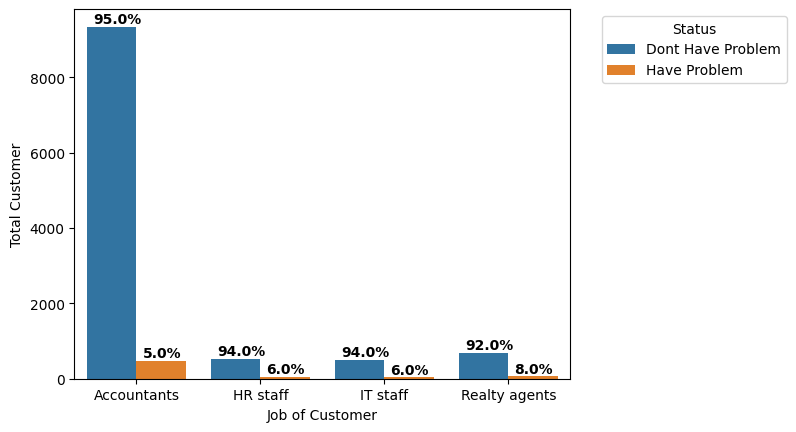

In [37]:
# Filter hanya data yang berhubungan dengan pekerjaan HR staff, IT staff, Realty agents, dan Accountants
ot_2 = ot[ot['OCCUPATION_TYPE'].isin(['HR staff', 'IT staff', 'Realty agents', 'Accountants'])]

# Mengatur ulang indeks setelah filtering
ot_2 = ot_2.reset_index(drop=True)

# Mengubah nilai TARGET menjadi label yang lebih deskriptif
mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}
ot_2['TARGET'] = ot_2['TARGET'].map(mapping_target)

# Membuat diagram batang (bar plot) untuk memvisualisasikan data
ax = sns.barplot(x='OCCUPATION_TYPE', y='Customers', hue='TARGET', data=ot_2)
plt.xlabel('Job of Customer')  # Memberi label sumbu x
plt.ylabel('Total Customer')  # Memberi label sumbu y
plt.legend(title='Status', bbox_to_anchor=(1.45, 1))  # Menambahkan legenda dan menyesuaikan posisinya

# Menambahkan label persentase di atas setiap batang
for i, v in enumerate(ot_2['Customers']):
    if i % 2 == 0:
        plt.text(i / 2 - 0.35, v + 100, s=str(ot_2['percentage'][i] * 100) + '%', color='black', fontweight='bold')
    else:
        plt.text(i / 2 - 0.45, v + 100, s=str(ot_2['percentage'][i] * 100) + '%', color='black', fontweight='bold')

plt.show(ax)

# **AGE OF THE CUSTOMER (Usia Pelanggan)**

In [38]:
# Menambahkan kolom baru 'Age' ke dalam DataFrame yang berisi informasi umur pelanggan.
# Perhitungan umur didasarkan pada data dalam kolom 'DAYS_BIRTH'.
# Menggunakan fungsi np.floor() untuk membulatkan hasil pembagian ke bawah agar mendapatkan nilai umur yang tepat.
# Kemudian, hasil perhitungan umur dikonversi menjadi tipe data integer menggunakan .astype(int).
df['Age'] = np.floor(df['DAYS_BIRTH'] / -365).astype(int)

# Menghapus kolom 'DAYS_BIRTH' dari DataFrame karena informasi tersebut sudah tidak diperlukan lagi setelah perhitungan umur dilakukan.
df.drop(columns='DAYS_BIRTH', inplace=True)



> Mengelompokkan usia pelanggan berdasarkan kriteria berikut:
1.   "Young Adult" untuk usia 20-35 tahun bagi pelanggan di bawah 36 tahun,
2.   "Adult" untuk usia 35-50 tahun bagi pelanggan dengan usia antara 36 dan 50 tahun, dan
3.   "Older" untuk pelanggan di atas 50 tahun.



In [39]:
# Mengelompokkan usia pelanggan ke dalam kategori usia berdasarkan aturan yang diberikan
age_cat = []
for i in df['Age']:
    if i < 36:
        age_cat.append('Young Adult')  # Usia < 36: Kategori "Young Adult"
    elif i < 51:
        age_cat.append('Adult')  # Usia 36-50: Kategori "Adult"
    else:
        age_cat.append('Older')  # Usia > 50: Kategori "Older"

# Menambahkan kolom kategori usia ke dalam dataframe
df['Age_category'] = age_cat

In [40]:
# Mengelompokkan data berdasarkan kategori usia pelanggan ('Age_category') dan status TARGET ('TARGET')
g_age = df.groupby(['TARGET', 'Age_category'])['CODE_GENDER'].count().reset_index().sort_values('Age_category').reset_index()

# Mengubah nama kolom 'CODE_GENDER' menjadi 'Customers'
g_age.rename(columns={'CODE_GENDER': 'Customers'}, inplace=True)

# Menghapus kolom 'index' yang tidak diperlukan
g_age.drop(columns='index', inplace=True)

# Membuat daftar unik dari kategori usia ('Age_category')
name_of_ot = list(g_age['Age_category'].unique())

# Menghitung persentase pelanggan dalam setiap kelompok usia
percentage = []
for i in name_of_ot:
    data = g_age[g_age['Age_category'] == i]
    total = data['Customers'].sum()
    for x, y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

# Menambahkan kolom 'percentage' ke dalam dataframe
g_age['percentage'] = percentage

# Mengubah nilai numerik dalam kolom 'TARGET' menjadi label yang lebih deskriptif
mapping_target = {
    1: 'Have Problem',
    0: 'Dont Have Problem'
}
g_age['TARGET'] = g_age['TARGET'].map(mapping_target)

g_age

,TARGET,Age_category,Customers,percentage
0,Dont Have Problem,Adult,108678,0.92
1,Have Problem,Adult,9403,0.08
2,Dont Have Problem,Older,91718,0.94
3,Have Problem,Older,5469,0.06
4,Dont Have Problem,Young Adult,82290,0.89
5,Have Problem,Young Adult,9953,0.11




> Dari tabel tersebut, dapat disimpulkan bahwa mayoritas pelanggan dari kategori usia "Adult" dan "Older" mampu membayar pinjaman tepat waktu, dengan persentase masing-masing sebesar 92% dan 94%. Namun, ada sebagian pelanggan dari kedua kategori usia tersebut yang mengalami kesulitan dalam membayar pinjaman, dengan persentase sebesar 8% untuk kategori "Adult" dan 6% untuk kategori "Older". Di sisi lain, kategori usia "Young Adult" memiliki persentase pelanggan yang mengalami kesulitan dalam membayar pinjaman yang lebih tinggi, yaitu sebesar 11%, meskipun mayoritas pelanggan dari kategori ini masih mampu membayar pinjaman tepat waktu.



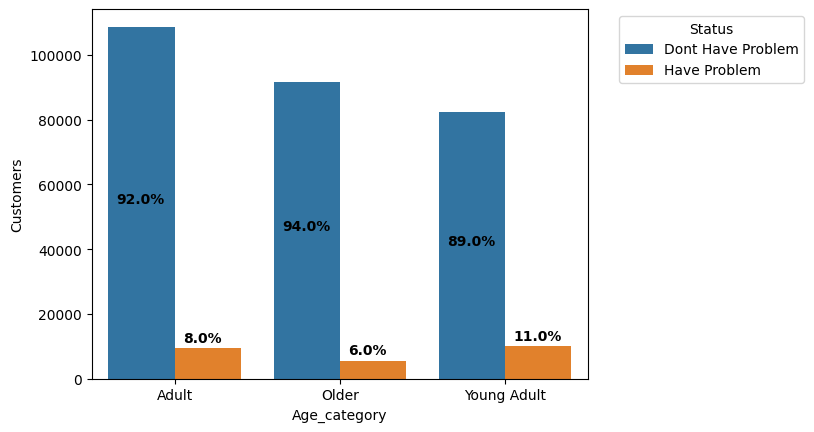

In [41]:
ax = sns.barplot(x='Age_category', y='Customers', hue='TARGET', data=g_age)
plt.legend(title='Status', bbox_to_anchor=(1.45, 1))

# Menambahkan label persentase di atas setiap bar
for i, v in enumerate(g_age['Customers']):
    if i % 2 == 0:
        plt.text(i / 2 - 0.35, v / 2, s=str(g_age['percentage'][i] * 100) + '%', color='black', fontweight='bold')
    else:
        plt.text(i / 2 - 0.45, v + 2000, s=str(g_age['percentage'][i] * 100) + '%', color='black', fontweight='bold')

plt.show(ax)



> Dari visualisasi di atas, dapat dilihat bahwa kategori usia Dewasa (35-50 tahun) memiliki jumlah pengajuan pinjaman terbanyak, di mana 92% pinjaman tersebut berhasil dilunasi tanpa masalah pembayaran. Hal ini menunjukkan bahwa menargetkan orang dewasa untuk mengajukan pinjaman di Kredit Rumah Indonesia bisa menjadi strategi yang efektif.



In [42]:
#Menghapus kolom 'Age_category' dari dataframe df
df.drop(columns = 'Age_category', inplace=True)

# **INCOME TYPE OF CONSUMER (Jenis Pendapatan konsumen)**

In [43]:
itc = df.groupby(['TARGET', 'NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(['NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE']).reset_index()
itc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
itc.drop(columns = 'index', inplace=True)

income_type   = list(itc['NAME_INCOME_TYPE'].unique())
percentage  = []

for i in income_type:
    data = itc[itc.NAME_INCOME_TYPE == i]
    contract_type = list(data['NAME_CONTRACT_TYPE'].unique())
    for x in contract_type:
        data2 = data[data.NAME_CONTRACT_TYPE == x]
        total = data2['Customers'].sum()
        for y,z in enumerate(data2['Customers']):
            pct = round(z / total, 2)
            percentage.append(pct)

itc['percentage'] = percentage
itc

,TARGET,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,Customers,percentage
0,0,Businessman,Revolving loans,10,1.00
1,0,Commercial associate,Cash loans,58662,0.92
2,1,Commercial associate,Cash loans,4990,0.08
3,0,Commercial associate,Revolving loans,7595,0.95
4,1,Commercial associate,Revolving loans,370,0.05
5,1,Maternity leave,Cash loans,2,1.00
6,0,Maternity leave,Revolving loans,3,1.00
7,0,Pensioner,Cash loans,49151,0.95
8,1,Pensioner,Cash loans,2842,0.05
9,0,Pensioner,Revolving loans,3229,0.96



Kesimpulan dari data diatas ialah:
*   Mayoritas pelanggan dengan penghasilan 'Businessman', 'Maternity leave', 'Pensioner', 'State servant', 'Student', dan 'Unemployed' memiliki tingkat kesuksesan pembayaran pinjaman 100%.
*   Pelanggan 'Commercial associate' memiliki tingkat kesuksesan tinggi baik pada pinjaman tunai (92%) maupun bergulir (95%), meskipun sedikit lebih rendah untuk pelanggan yang kesulitan pembayaran (5%).
* Pelanggan 'Pensioner' menunjukkan kesuksesan tinggi baik pada pinjaman tunai (95%) maupun bergulir (96%), dengan kegagalan pembayaran yang rendah.
* Pelanggan 'State servant' juga memiliki kesuksesan tinggi pada pinjaman tunai (94%) dan bergulir (97%), meskipun lebih banyak kesulitan pada pinjaman tunai (6%) dibanding bergulir (3%).
*Mayoritas pelanggan 'Working' mampu membayar pinjaman tepat waktu, dengan tingkat kesuksesan sekitar 90-94% pada pinjaman tunai dan 6-10% pada pinjaman bergulir.
* Jenis penghasilan pelanggan memengaruhi kemampuan mereka membayar pinjaman, dengan beberapa jenis menunjukkan tingkat kesuksesan yang lebih tinggi.



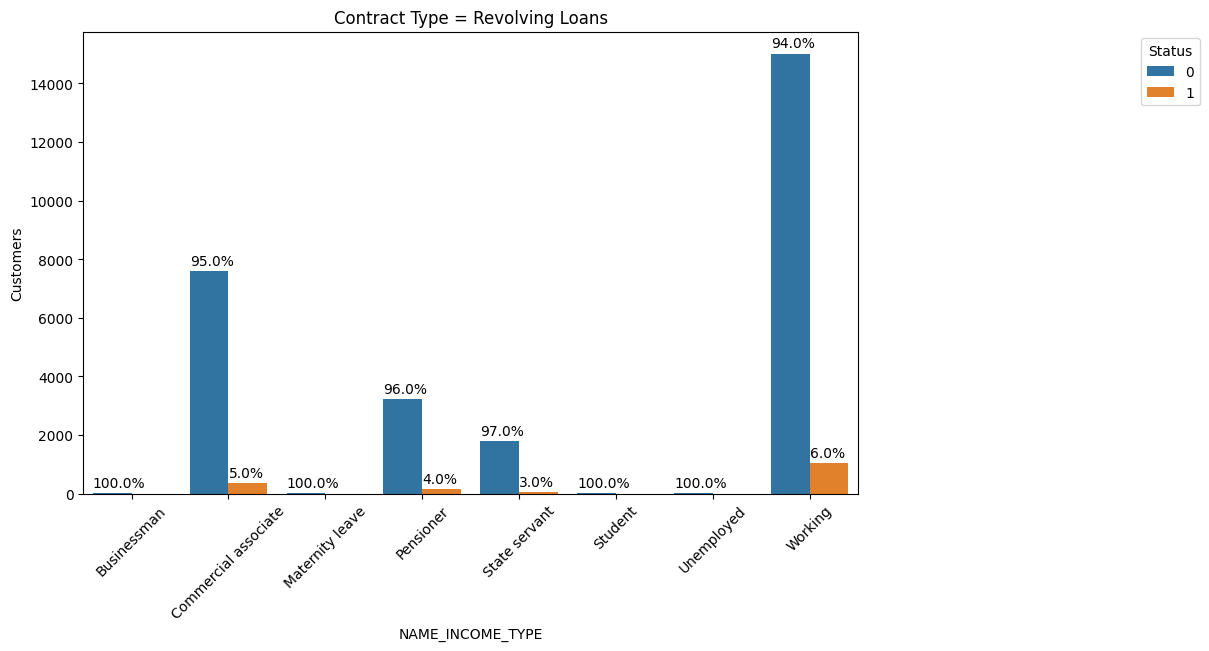

In [47]:
# Mengurutkan DataFrame itc_rl berdasarkan kolom 'TARGET' dan mereset indeks
itc_rl = itc[itc['NAME_CONTRACT_TYPE'] == 'Revolving loans'].reset_index(drop=True)

# Membuat gambar dengan ukuran yang lebih kecil
plt.figure(figsize=(10, 6))

# Membuat barplot menggunakan seaborn
ax = sns.barplot(x='NAME_INCOME_TYPE', y='Customers', data=itc_rl, hue='TARGET')
plt.title('Contract Type = Revolving Loans')
plt.xticks(rotation=45)
plt.legend(title='Status', bbox_to_anchor=(1.45, 1))

# Mengurutkan DataFrame itc_rl berdasarkan kolom 'TARGET' dan mereset indeks
itc_p = itc_rl.sort_values('TARGET').reset_index(drop=True)

# Menghitung jumlah bar yang akan diiterasi
num_bars = min(len(itc_p), len(ax.patches))

# Menambahkan label persentase di atas setiap bar
for i in range(num_bars):
    p = ax.patches[i]
    width, height = p.get_x(), p.get_height()
    plt.text(width, height + 200, s=str(itc_p['percentage'][i] * 100) + '%')

plt.show()

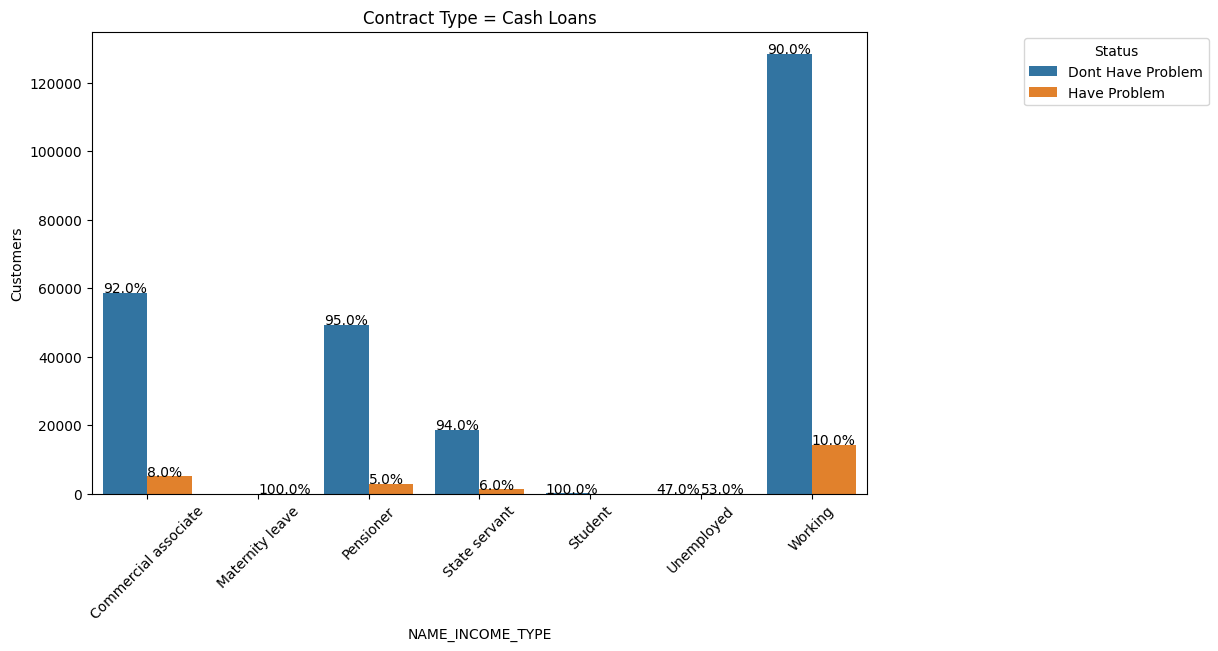

In [48]:
# Memfilter DataFrame untuk hanya mengambil baris-baris dengan 'NAME_CONTRACT_TYPE' sama dengan 'Cash loans',
# lalu mereset ulang indeksnya.
itc_cl = itc[itc['NAME_CONTRACT_TYPE'] == 'Cash loans'].reset_index(drop=True)

# Membuat peta pemetaan untuk mengubah nilai dalam kolom 'TARGET'.
# Nilai 1 direpresentasikan sebagai 'Have Problem' dan nilai 0 direpresentasikan sebagai 'Dont Have Problem'.
mapping_target = {
    1: 'Have Problem',
    0: 'Dont Have Problem'
}

# Menggunakan pemetaan yang telah dibuat untuk mengubah nilai dalam kolom 'TARGET'.
itc_cl['TARGET'] = itc_cl['TARGET'].map(mapping_target)

# Mengatur ukuran gambar sebelum membuat plot
plt.figure(figsize=(10, 6))

# Membuat barplot menggunakan seaborn, dengan sumbu x adalah 'NAME_INCOME_TYPE', sumbu y adalah 'Customers',
# dan bar dibagi berdasarkan status 'TARGET' ('Have Problem' dan 'Dont Have Problem').
ax = sns.barplot(x='NAME_INCOME_TYPE', y='Customers', data=itc_cl, hue='TARGET')
plt.title('Contract Type = Cash Loans')
plt.xticks(rotation=45)
plt.legend(title='Status', bbox_to_anchor=(1.45, 1))

# Mengurutkan DataFrame itc_cl berdasarkan kolom 'TARGET' dan mereset ulang indeksnya.
itc_p2 = itc_cl.sort_values('TARGET').reset_index(drop=True)

# Menambahkan label persentase di atas setiap bar pada plot.
for i, p in enumerate(ax.patches):
    width, height = p.get_x(), p.get_height()
    if not np.isnan(height) and i < len(itc_p2):  # Periksa apakah i berada dalam jangkauan indeks DataFrame
        plt.text(width, height + 200, s=str(itc_p2['percentage'][i] * 100) + '%')

plt.show()

In [49]:
itc_cl

,TARGET,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,Customers,percentage
0,Dont Have Problem,Commercial associate,Cash loans,58662,0.92
1,Have Problem,Commercial associate,Cash loans,4990,0.08
2,Have Problem,Maternity leave,Cash loans,2,1.00
3,Dont Have Problem,Pensioner,Cash loans,49151,0.95
4,Have Problem,Pensioner,Cash loans,2842,0.05
5,Dont Have Problem,State servant,Cash loans,18648,0.94
6,Have Problem,State servant,Cash loans,1188,0.06
7,Dont Have Problem,Student,Cash loans,15,1.00
8,Dont Have Problem,Unemployed,Cash loans,7,0.47
9,Have Problem,Unemployed,Cash loans,8,0.53




> Berdasarkan data, mayoritas pelanggan dengan 'Cash loans' berasal dari pekerjaan 'Working', 'Commercial associate', dan 'Pensioner'. Sebagian besar dari mereka tidak memiliki masalah pembayaran. Namun, pelanggan yang mengalami masalah pembayaran cenderung berasal dari golongan pekerja 'Working'. Meskipun jumlah pelanggan dengan masalah pembayaran umumnya lebih rendah, persentase tersebut bervariasi antar jenis pekerjaan. Sebagai contoh, persentase pelanggan dengan masalah pembayaran relatif lebih tinggi di antara 'Commercial associate' dan 'Unemployed'.



# **DATA CLEANING (Pembersihan Data)**

**Mendeteksi dan Menghapus Duplikat Data**

In [50]:
#Menghitung jumlah baris duplikat dalam DataFrame df
df.duplicated().sum()

0

# **DETECTING MISSING VALUE (Mendeteksi nilai yang hilang)**

In [51]:
# Hitung total data yang hilang dalam setiap kolom dan simpan dalam DataFrame baru
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()

# Hitung persentase data yang hilang dalam setiap kolom
count_nv['Percentage'] = (count_nv['Total Null Data'] / len(df)) * 100

# Filter kolom-kolom dengan persentase data yang hilang lebih dari 40% dan urutkan secara menurun
count_nv_high_missing = count_nv[count_nv['Percentage'] > 40].sort_values(by='Percentage', ascending=False)

# Tampilkan DataFrame hasil filter
print(count_nv_high_missing)

                           index  Total Null Data  Percentage
46                COMMONAREA_AVG           214865   69.872297
74               COMMONAREA_MEDI           214865   69.872297
60               COMMONAREA_MODE           214865   69.872297
82      NONLIVINGAPARTMENTS_MEDI           213514   69.432963
68      NONLIVINGAPARTMENTS_MODE           213514   69.432963
54       NONLIVINGAPARTMENTS_AVG           213514   69.432963
84            FONDKAPREMONT_MODE           210295   68.386172
80         LIVINGAPARTMENTS_MEDI           210199   68.354953
52          LIVINGAPARTMENTS_AVG           210199   68.354953
66         LIVINGAPARTMENTS_MODE           210199   68.354953
64                FLOORSMIN_MODE           208642   67.848630
78                FLOORSMIN_MEDI           208642   67.848630
50                 FLOORSMIN_AVG           208642   67.848630
59              YEARS_BUILD_MODE           204488   66.497784
45               YEARS_BUILD_AVG           204488   66.497784
73      



> Kami akan mengeliminasi fitur-fitur yang memiliki lebih dari 40% data yang bernilai nol.



In [52]:
#Memilih kolom-kolom yang memiliki persentase data null lebih dari 40%
data = list(count_nv[count_nv['Percentage'] > 40]['index'])

#Menghapus kolom-kolom yang terdapat dalam data dari DataFrame df
#Selain itu, juga menghapus kolom 'SK_ID_CURR' dari DataFrame df
df.drop(columns=data, inplace=True)
df.drop(columns='SK_ID_CURR', inplace=True)

In [53]:
# Hitung total data yang hilang dalam setiap kolom dan simpan dalam DataFrame baru
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()

# Hitung persentase data yang hilang dalam setiap kolom
count_nv['Percentage'] = (count_nv['Total Null Data'] / len(df)) * 100

#Menyimpan informasi tentang kolom-kolom yang masih memiliki nilai null setelah dihitung persentasenya
still_null = count_nv[count_nv['Percentage'] != 0].sort_values(by='Percentage', ascending=False)

In [54]:
a = list(still_null['index'])  # Membuat daftar kolom yang masih memiliki nilai null

df[a].dtypes  # Menampilkan tipe data dari kolom-kolom yang masih memiliki nilai null

for i in a:  # Iterasi melalui setiap kolom yang masih memiliki nilai null
    data = df[i]  # Mengambil data dari kolom yang sedang diproses
    types = str(data.dtype)  # Mendapatkan tipe data kolom
    if types == 'object':  # Jika tipe data adalah objek (misalnya, string)
        df[i].fillna(df[i].mode()[0], inplace=True)  # Mengganti nilai null dengan nilai modus
    else:  # Jika tipe data adalah numerik
        df[i].fillna(df[i].median(), inplace=True)  # Mengganti nilai null dengan median

In [55]:
# Hitung total data yang hilang dalam setiap kolom dan simpan dalam DataFrame baru
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()

# Hitung persentase data yang hilang dalam setiap kolom
count_nv['Percentage'] = (count_nv['Total Null Data'] / len(df)) * 100

#Menampilkan kolom-kolom yang memiliki nilai null
count_nv[count_nv['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage


# **REPLACE UNKNOWN VALUE (Ganti Nilai yang Tidak Diketahui)**

In [56]:
# Mengganti nilai 'XNA' dalam kolom 'CODE_GENDER' dengan nilai modus
df['CODE_GENDER'] = df['CODE_GENDER'].replace(['XNA'], df['CODE_GENDER'].mode()[0])

# Mengganti nilai 'XNA' dalam kolom 'ORGANIZATION_TYPE' dengan nilai modus
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(['XNA'], df['ORGANIZATION_TYPE'].mode()[0])

# Tampilkan DataFrame setelah perubahan
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Marital_status,Age
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,Unmarried,25
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Married,45
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Unmarried,52
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,Married,52
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Unmarried,54


# **REMOVE FLAG DOCUMENT COLUMN (Hapus Kolom Dokumen Bendera)**

In [57]:
# Membuat list FLAG_DOCUMENT yang berisi nama-nama kolom yang mengandung substring 'FLAG_DOCUMENT'
FLAG_DOCUMENT = [col for col in df.columns if 'FLAG_DOCUMENT' in col]

# Menghapus kolom-kolom yang ada dalam list FLAG_DOCUMENT dari DataFrame df
df.drop(columns=FLAG_DOCUMENT, axis=1, inplace=True)

# **FEATURE ENGINEERING (Rekayasa Fitur)**

In [58]:
# Menghapus kolom 'TARGET' dari DataFrame df dan menyimpan DataFrame baru dalam variabel x
x = df.drop(columns='TARGET')

# **NUMERIC DATA TYPE (Tipe Data Numerik)**

In [59]:
#Memilih kolom-kolom dalam DataFrame x yang memiliki tipe data numerik (bilangan) dan menyimpannya dalam variabel num
num = x.select_dtypes(include='number')

num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-637,-3648.0,-2120,1,...,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1188,-1186.0,-291,1,...,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-225,-4260.0,-2531,1,...,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-3039,-9833.0,-2437,1,...,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0,52
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-3038,-4311.0,-3458,1,...,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,54


**Ubah Nilai Negatif pada Kolom menjadi Nilai Positif**

In [60]:
negative_column = num.columns[(num < 0).any()].tolist()  # Memilih kolom-kolom yang memiliki nilai negatif
num[negative_column] = num[negative_column].abs()  # Mengubah nilai-nilai negatif menjadi positif menggunakan fungsi abs()

num.head()  # Menampilkan lima baris pertama dari DataFrame num setelah perubahan

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,637,3648.0,2120,1,...,2.0,2.0,1134.0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,1188,1186.0,291,1,...,1.0,0.0,828.0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,225,4260.0,2531,1,...,0.0,0.0,815.0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,3039,9833.0,2437,1,...,2.0,0.0,617.0,0.0,0.0,0.0,0.0,0.0,1.0,52
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,3038,4311.0,3458,1,...,0.0,0.0,1106.0,0.0,0.0,0.0,0.0,0.0,0.0,54


**Cari Tipe Data Numerik yang memiliki Nilai Unik > 2**

In [61]:
df_num = pd.DataFrame(num.nunique(), columns=['Total_unique']).reset_index()  # Menghitung jumlah nilai unik untuk setiap kolom numerik
df_num = df_num.rename(columns={'index': 'Name_of_column'})  # Mengubah nama kolom indeks menjadi 'Name_of_column'

num_a = []  # Membuat daftar untuk kolom-kolom dengan lebih dari dua nilai unik
num_b = []  # Membuat daftar untuk kolom-kolom dengan dua atau kurang nilai unik

# Iterasi melalui setiap baris dalam DataFrame df_num
for i, y in enumerate(df_num['Name_of_column']):  # Memodifikasi bagian ini untuk sesuai dengan penggunaan kolom 'Name_of_column'
    if df_num.iloc[i, 1] > 2:  # Menggunakan iloc untuk mengakses jumlah nilai unik
        num_a.append(y)  # Tambahkan nama kolom ke dalam num_a
    else:  # Jika jumlah nilai unik dua atau kurang
        num_b.append(y)  # Tambahkan nama kolom ke dalam num_b

**Lihatlah Sebaran Datanya**

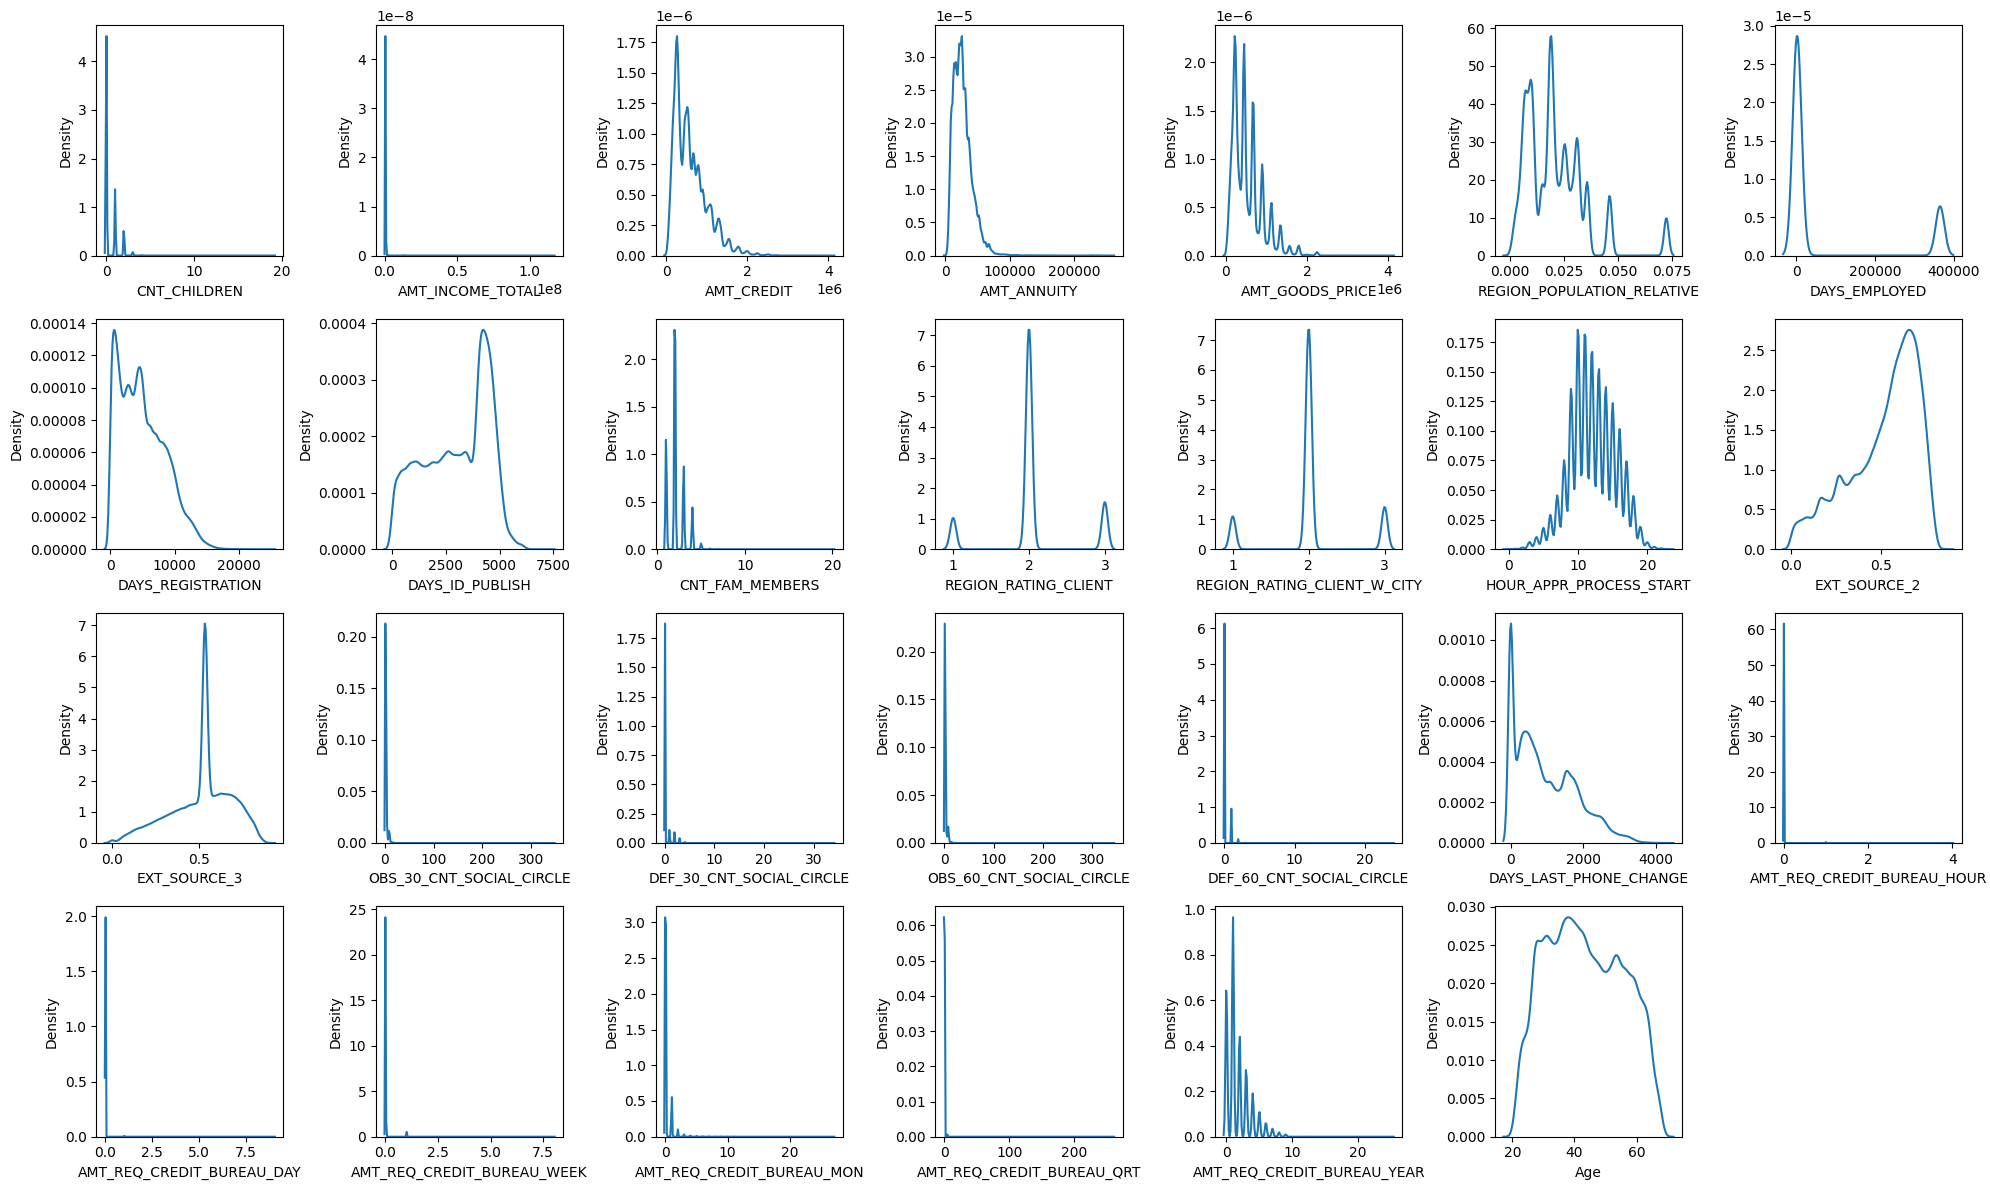

In [62]:
plt.figure(figsize=(20, 12))  # Membuat gambar berukuran 20x12 inci untuk menampung subplot

for i, column in enumerate(num[num_a].columns, 1):  # Melakukan iterasi melalui setiap kolom dalam DataFrame num yang termasuk dalam num_a
    plt.subplot(4, 7, i)  # Membuat subplot dengan ukuran 4 baris dan 7 kolom, diatur sesuai nomor iterasi
    sns.kdeplot(data=num[num_a], x=column)  # Membuat plot kepadatan kernel untuk data dalam kolom yang sedang diproses
    plt.tight_layout()  # Mengoptimalkan tata letak subplot



> Dari hasil diatas menandakan bahwa distribusi data belum menyerupai distribusi normal, oleh karena itu, normalisasi perlu dilakukan.



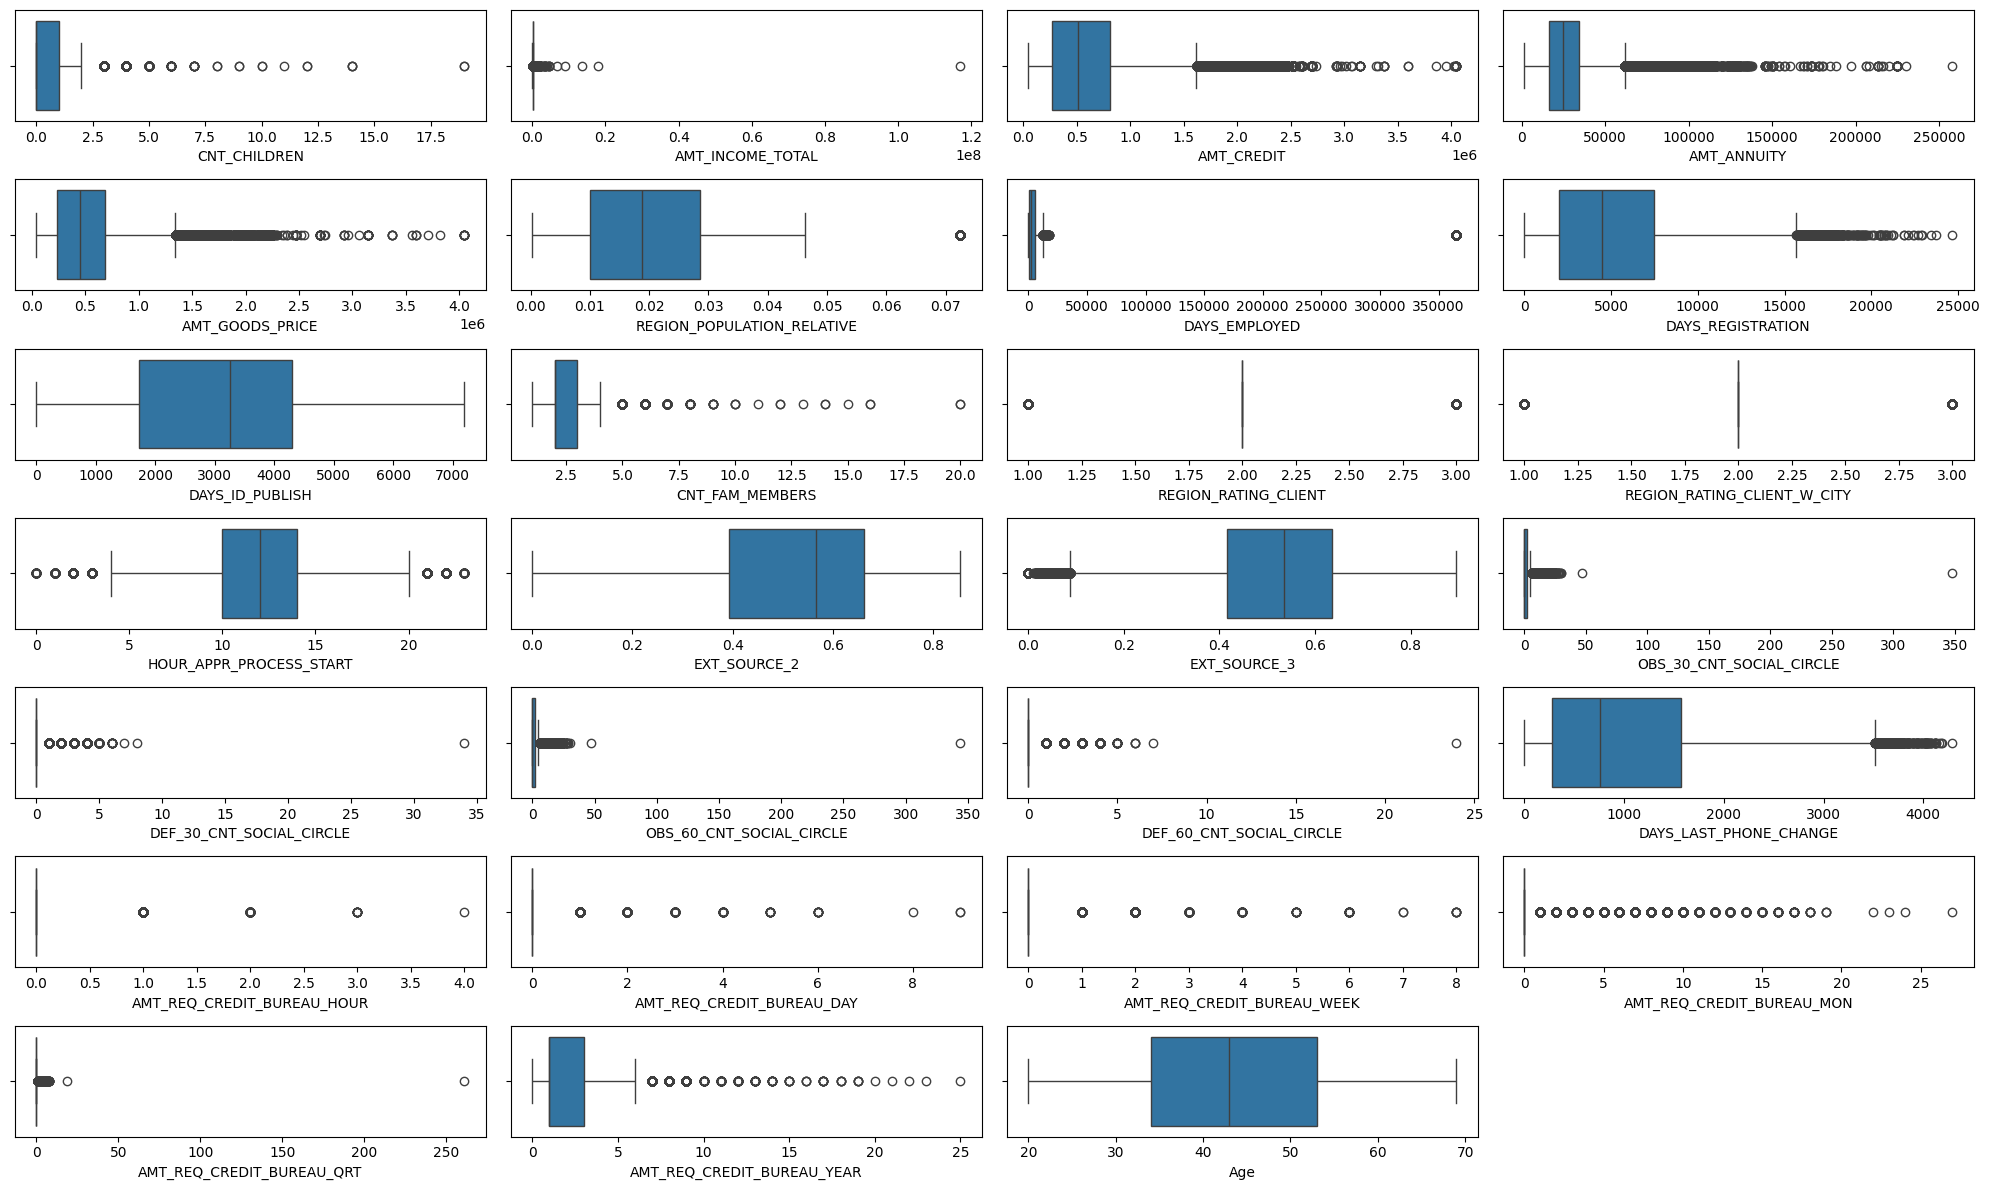

In [63]:
plt.figure(figsize=(20, 12)) #Membuat gambar dengan ukuran 20x12

for i, column in enumerate(num[num_a].columns, 1): #Melakukan iterasi melalui kolom-kolom dalam num_a
    plt.subplot(7, 4, i) #Membuat subplot dengan 7 baris dan 4 kolom, dengan nomor subplot ditentukan oleh i
    sns.boxplot(data=num[num_a], x=column)  # Menggunakan variabel 'column' langsung tanpa menggunakan num[column] #Membuat boxplot untuk kolom yang sedang diproses (ditentukan oleh column) dari DataFrame num yang hanya berisi kolom-kolom dari num_a.
    plt.tight_layout() #Memastikan layout subplot yang lebih rapi



> Berdasarkan hasil di atas, terlihat bahwa kolom yang memiliki data yang tidak normal adalah kolom cnt_children. Oleh karena itu, diperlukan tindakan untuk menghilangkan nilai-nilai ekstrem (outlier) dalam kolom tersebut.



# **REMOVE OUTLIER (Hapus Pencilan)**

In [64]:
# Cetak jumlah baris sebelum menghapus outlier di kolom 'CNT_CHILDREN'
print(f'Row before delete outlier at CNT_children : {len(df)}')

# Buat array Boolean untuk menyimpan status entri yang akan dipertahankan
filtered_entries = np.array([True] * len(df))

# Hitung nilai z-score absolut dari kolom 'CNT_CHILDREN'
zscore = abs(stats.zscore(df['CNT_CHILDREN']))

# Perbarui array filtered_entries dengan menyaring nilai z-score yang kurang dari 3
filtered_entries = (zscore < 3) & filtered_entries

# Filter DataFrame berdasarkan array filtered_entries
df = df[filtered_entries]

# Cetak jumlah baris setelah menghapus outlier di kolom 'CNT_CHILDREN'
print(f'Row after delete outlier at CNT_children : {len(df)}')

Row before delete outlier at CNT_children : 307511
Row after delete outlier at CNT_children : 303239


In [65]:
x = df.drop(columns='TARGET', axis=1).copy()  # Menghapus kolom 'TARGET' dari DataFrame df dan menyimpan DataFrame baru ke dalam variabel x
num = x[num_a].copy()  # Memilih kolom-kolom yang telah disaring berdasarkan daftar num_a dari DataFrame x

In [66]:
num_mean = num.mean()  # Menghitung rata-rata dari setiap kolom numerik
num_std = num.std()    # Menghitung standar deviasi dari setiap kolom numerik

num = (num - num_mean) / num_std  # Normalisasi data dengan mengurangkan rata-rata dan membagi dengan standar deviasi
num.head()  # Menampilkan lima baris pertama dari DataFrame num setelah normalisasi

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,-0.589198,0.141631,-0.477744,-0.165346,-0.506964,-0.150759,-0.459710,0.385831,0.577304,-1.320962,...,0.252564,5.254914,-0.206172,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,-1.544674
1,-0.589198,0.424753,1.725509,0.594213,1.600729,-1.253789,-0.463592,1.083617,1.789288,-0.131831,...,-0.168056,-0.275683,0.163731,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.122835
2,-0.589198,-0.424615,-1.152447,-1.405069,-1.091757,-0.784603,-0.456807,0.212377,0.304955,-1.320962,...,-0.588676,-0.275683,0.179446,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.706463
3,-0.589198,-0.141492,-0.711048,0.179004,-0.653162,-0.930108,-0.476632,-1.367137,0.367244,-0.131831,...,0.252564,-0.275683,0.418795,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,0.706463
4,-0.589198,-0.198116,-0.213418,-0.361141,-0.068369,0.562091,-0.476625,0.197922,-0.309320,-1.320962,...,-0.588676,-0.275683,-0.172324,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.873213


In [67]:
num_1 = x[num_b]  # Memilih kolom-kolom dengan dua atau kurang nilai unik
num_1 = num_1.loc[~num_1.index.duplicated(keep='first')]  # Menghapus duplikat baris

num = pd.concat([num, num_1], axis=1)  # Menggabungkan DataFrame num dengan DataFrame num_1
num.reset_index(drop=True, inplace=True)  # Mereset indeks DataFrame num
num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,-0.589198,0.141631,-0.477744,-0.165346,-0.506964,-0.150759,-0.459710,0.385831,0.577304,-1.320962,...,0,1,1,0,0,0,0,0,0,0
1,-0.589198,0.424753,1.725509,0.594213,1.600729,-1.253789,-0.463592,1.083617,1.789288,-0.131831,...,0,1,1,0,0,0,0,0,0,0
2,-0.589198,-0.424615,-1.152447,-1.405069,-1.091757,-0.784603,-0.456807,0.212377,0.304955,-1.320962,...,1,1,1,0,0,0,0,0,0,0
3,-0.589198,-0.141492,-0.711048,0.179004,-0.653162,-0.930108,-0.476632,-1.367137,0.367244,-0.131831,...,0,1,0,0,0,0,0,0,0,0
4,-0.589198,-0.198116,-0.213418,-0.361141,-0.068369,0.562091,-0.476625,0.197922,-0.309320,-1.320962,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303234,-0.589198,-0.047118,-0.855088,0.032003,-0.848093,0.843848,-0.456884,-0.976864,0.668749,-1.320962,...,0,1,0,0,0,0,0,0,0,0
303235,-0.589198,-0.405740,-0.818198,-1.042382,-0.848093,0.309175,2.118014,0.176098,-0.728114,-1.320962,...,0,1,1,0,0,0,0,0,0,0
303236,-0.589198,-0.065993,0.195641,0.199205,0.126562,-1.148184,-0.511027,-0.489661,-1.430522,-1.320962,...,0,1,0,1,0,0,0,0,1,1
303237,-0.589198,0.009507,-0.568393,-0.475821,-0.592246,-1.125704,-0.488940,0.693628,1.365193,-0.131831,...,0,1,0,0,0,0,0,1,1,0


# **OBJECT DATA TYPE (Tipe Data Objek)**

**Feature Transformation (Transformasi Fitur)**

In [68]:
obj = x.select_dtypes(include='object') #Memilih kolom-kolom dalam DataFrame x
df_obj = pd.DataFrame(obj.nunique(), columns=['Total_unique']).reset_index() #Menghitung jumlah nilai unik untuk setiap kolom dalam DataFrame obj
df_obj = df_obj.rename(columns={'index': 'Name_of_column'}) #Mengganti nama kolom indeks menjadi 'Name_of_column' agar lebih deskriptif

#Mendefinisikan dua list kosong untuk menampung nama kolom dengan jumlah nilai unik lebih dari 2 (obj_1) dan 2 atau kurang (obj_2)
obj_1 = []
obj_2 = []
for i, y in enumerate(df_obj.Name_of_column): #Melakukan iterasi melalui nama kolom dalam DataFrame df_obj
    if df_obj['Total_unique'][i] > 2: #Memeriksa apakah jumlah nilai unik dalam kolom tersebut lebih dari 2
        obj_1.append(y) #Jika jumlah nilai unik lebih dari 2, maka nama kolomnya ditambahkan ke dalam list obj_1
    else: #Jika jumlah nilai unik 2 atau kurang, maka nama kolomnya ditambahkan ke dalam list obj_2
        obj_2.append(y)

# Menampilkan hasil
obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,Marital_status
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Unmarried
1,Cash loans,F,N,N,Family,State servant,Higher education,House / apartment,Core staff,MONDAY,School,Married
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,MONDAY,Government,Unmarried
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Married
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Core staff,THURSDAY,Religion,Unmarried
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,With parents,Sales staff,THURSDAY,Services,Unmarried
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,House / apartment,Laborers,MONDAY,Business Entity Type 3,Unmarried
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,House / apartment,Managers,THURSDAY,School,Unmarried
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,Married


**One Hot Encoding**

In [69]:
# Menghasilkan one-hot encoding dan menghapus kolom kategorikal asli dalam satu baris
obj = obj.join(pd.get_dummies(obj[obj_1], prefix=obj_1)).drop(columns=obj_1)

**Label Encoding**

In [70]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in columns specified in obj_2.
obj[obj_2] = obj[obj_2].apply(label_encoder.fit_transform)

obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,Marital_status,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University
0,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307507,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307508,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307509,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
#Menggabungkan dua DataFrame, yaitu num dan obj secara horizontal
df_train = pd.concat([num, obj], axis=1)

In [72]:
df = pd.concat([df_train, df['TARGET']], axis=1) # Menggabungkan DataFrame df_train dengan kolom TARGET dari DataFrame df secara horizontal

# **DATA SPLITTING (Pemisahan data)**

In [73]:
x = df.drop(columns='TARGET')  # Memilih semua kolom kecuali kolom 'TARGET' dari DataFrame df dan menyimpannya dalam variabel x
y = df['TARGET']  # Memilih kolom 'TARGET' dari DataFrame df dan menyimpannya dalam variabel y

# **OVERSAMPLING (Pengambilan sampel berlebihan)**

In [74]:
# Menggabungkan fitur dan label ke dalam satu DataFrame
df = pd.concat([x, y], axis=1)

# Menghapus baris yang mengandung nilai NaN
df = df.dropna()

# Memisahkan kembali fitur dan label setelah menghilangkan nilai NaN
x = df.drop(columns=['TARGET'])
y = df['TARGET']

# Menginisialisasi objek SMOTE dengan menentukan random_state
sm = SMOTE(random_state=2)

# Mengaplikasikan SMOTE untuk oversampling dataset
x_over, y_over = sm.fit_resample(x, y.ravel())

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.3, random_state=42)

# **UNDERSAMPLING (Pengambilan sampel yang rendah)**

In [76]:
# Membuat objek RandomUnderSampler dengan menentukan nilai random_state
rus = RandomUnderSampler(random_state=42)

# Mengaplikasikan undersampling pada dataset
x_under, y_under = rus.fit_resample(x, y.ravel())

In [77]:
# Membagi data yang telah diundersample menjadi data latih dan data uji
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_under, y_under, test_size=0.3, random_state=42)

# **TRAIN LOGISTIC REGRESSION MODEL**

**With oversampling Data**

In [78]:
def confusionmatrix(predictions, y_test):
    cm = confusion_matrix(y_test, predictions)  # Menghitung confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # Membuat objek untuk menampilkan confusion matrix
    disp.plot()  # Memplot confusion matrix
    plt.show()  # Menampilkan plot confusion matrix

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         0.0       0.62      0.60      0.61     82503
         1.0       0.62      0.64      0.63     82474

    accuracy                           0.62    164977
   macro avg       0.62      0.62      0.62    164977
weighted avg       0.62      0.62      0.62    164977



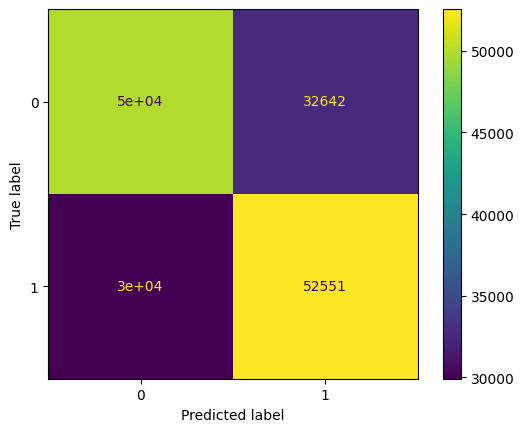

In [79]:
lr1 = LogisticRegression()  # Membuat objek model Logistic Regression
lr1.fit(x_train, y_train.ravel())  # Melatih model menggunakan data training
predictions = lr1.predict(x_test)  # Melakukan prediksi menggunakan data testing

# print classification report
print(classification_report(y_test, predictions))  # Menampilkan classification report untuk mengevaluasi performa model

# Menampilkan confusion matrix untuk mengevaluasi performa model
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()



> Dari hasil running tersebut, dapat disimpulkan bahwa model Logistic Regression yang telah dilatih memberikan performa yang cukup baik dalam melakukan prediksi pada data testing. Meskipun tingkat akurasi sebesar 62% menunjukkan bahwa model memiliki kemampuan untuk memprediksi label dengan benar, masih terdapat ruang untuk peningkatan performa. Hal ini terlihat dari nilai precision, recall, dan f1-score yang relatif rendah untuk kedua kelas, yaitu sekitar 62%. Dengan demikian, model ini mungkin dapat dioptimalkan lebih lanjut untuk meningkatkan kinerjanya dalam melakukan prediksi.


              precision    recall  f1-score   support

         0.0       0.63      0.60      0.62    192458
         1.0       0.62      0.64      0.63    192487

    accuracy                           0.62    384945
   macro avg       0.62      0.62      0.62    384945
weighted avg       0.62      0.62      0.62    384945



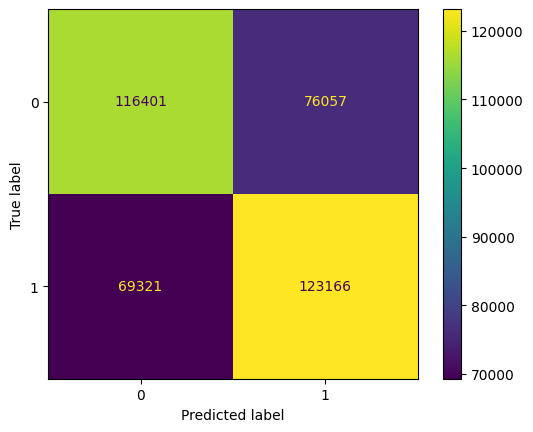

In [80]:
predictions = lr1.predict(x_train)  # Melakukan prediksi menggunakan data training

# Menampilkan classification report untuk data training
print(classification_report(y_train, predictions))

# Menampilkan confusion matrix untuk data training
confusionmatrix(predictions, y_train)



> Dari hasil running tersebut, dapat disimpulkan bahwa model Logistic Regression yang dilatih menggunakan data training memiliki performa yang cukup baik dalam memprediksi label pada data training tersebut. Tingkat akurasi sebesar 62% menunjukkan bahwa model memiliki kemampuan untuk memprediksi label dengan benar. Hal ini didukung oleh nilai precision, recall, dan f1-score yang relatif seimbang untuk kedua kelas, yaitu sekitar 62%. Dengan demikian, model ini dapat dianggap cukup baik dalam mempelajari pola dari data training.



**With Undersampling Data**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         0.0       0.59      0.57      0.58      7196
         1.0       0.58      0.60      0.59      7236

    accuracy                           0.58     14432
   macro avg       0.58      0.58      0.58     14432
weighted avg       0.58      0.58      0.58     14432



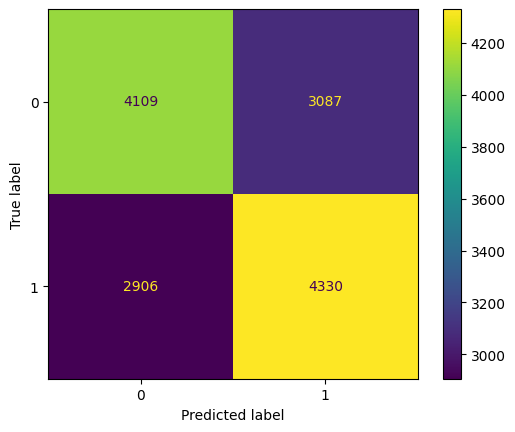

In [81]:
lr2 = LogisticRegression()  # Membuat objek model Logistic Regression
lr2.fit(x_train2, y_train2)  # Melatih model menggunakan data training
predictions2 = lr2.predict(x_test2)  # Melakukan prediksi menggunakan data testing

# print classification report
print(classification_report(y_test2, predictions2))  # Menampilkan classification report untuk mengevaluasi performa model

# Menampilkan confusion matrix untuk mengevaluasi performa model
cm2 = confusion_matrix(y_test2, predictions2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot()
plt.show()



> Dari hasil running tersebut, dapat disimpulkan bahwa model Logistic Regression yang dilatih menggunakan data training dengan teknik undersampling memiliki performa yang cukup baik dalam memprediksi label pada data testing. Namun, tingkat akurasi sebesar 58% menunjukkan bahwa model memiliki performa yang cukup rendah dalam memprediksi label dengan benar. Hal ini juga ditunjukkan oleh nilai precision, recall, dan f1-score yang relatif rendah untuk kedua kelas, yaitu sekitar 58%. Dengan demikian, model ini dapat dianggap memiliki kinerja yang kurang memuaskan dalam mempelajari pola dari data training.



              precision    recall  f1-score   support

         0.0       0.63      0.60      0.62    192458
         1.0       0.62      0.64      0.63    192487

    accuracy                           0.62    384945
   macro avg       0.62      0.62      0.62    384945
weighted avg       0.62      0.62      0.62    384945



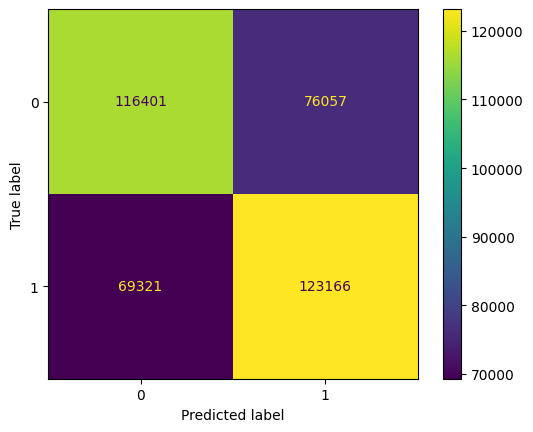

In [82]:
predictions = lr1.predict(x_train)  # Melakukan prediksi menggunakan data training

# Menampilkan classification report untuk data training
print(classification_report(y_train, predictions))

# Menampilkan confusion matrix untuk data training
confusionmatrix(predictions, y_train)



> Dari hasil running tersebut, dapat disimpulkan bahwa model Logistic Regression yang dilatih menggunakan data training memiliki performa yang cukup baik dalam memprediksi label pada data training itu sendiri. Tingkat akurasi sebesar 62% menunjukkan bahwa sekitar 62% dari prediksi model sesuai dengan label sebenarnya pada data training. Selain itu, nilai precision, recall, dan f1-score untuk kedua kelas juga relatif seimbang, dengan nilai sekitar 0.62 untuk setiap metrik. Oleh karena itu, model ini dapat dianggap memiliki kemampuan yang cukup baik dalam mempelajari pola dari data training.



# **TRAIN XGBoost MODEL**

**With Oversampling Data**

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     82503
         1.0       1.00      0.91      0.95     82474

    accuracy                           0.95    164977
   macro avg       0.96      0.95      0.95    164977
weighted avg       0.96      0.95      0.95    164977



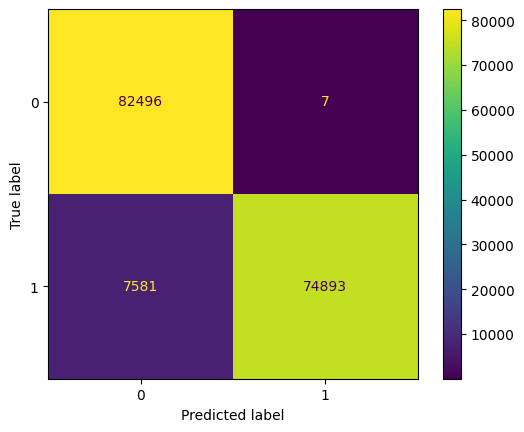

In [83]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)  #Membuat objek model XGBoost Classifier dengan fungsi logistik biner sebagai tujuan, dan menentukan nilai seed (random_state) untuk memastikan reproduktibilitas
xgb_model.fit(x_train, y_train.ravel())  #Melatih model menggunakan data training

predictions = xgb_model.predict(x_test)  #Melakukan prediksi menggunakan data testing

# print classification report
print(classification_report(y_test, predictions))  #Menampilkan laporan klasifikasi untuk mengevaluasi performa model
confusionmatrix(predictions, y_test)  #Menghitung confusion matrix untuk mengevaluasi performa model



> Dari hasil running tersebut, dapat disimpulkan bahwa model XGBoost Classifier yang telah dilatih memberikan performa yang sangat baik dalam melakukan prediksi. Hal ini ditunjukkan oleh tingkat akurasi sebesar 95%, serta nilai precision, recall, dan f1-score yang tinggi untuk kedua kelas. Dengan demikian, model tersebut dapat dianggap berhasil dalam mengklasifikasikan data dengan baik, dan cocok digunakan untuk keperluan prediksi pada dataset yang diberikan.



              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    192458
         1.0       1.00      0.91      0.95    192487

    accuracy                           0.96    384945
   macro avg       0.96      0.96      0.95    384945
weighted avg       0.96      0.96      0.95    384945



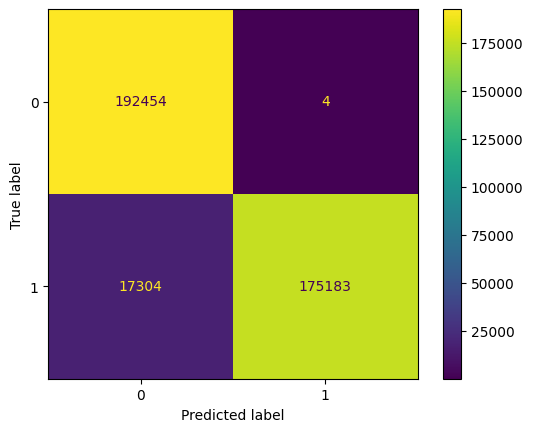

In [84]:
predictions = xgb_model.predict(x_train)  # Melakukan prediksi menggunakan data training

# Menampilkan classification report untuk data training
print(classification_report(y_train, predictions))

# Menampilkan confusion matrix untuk data training
confusionmatrix(predictions, y_train)



> Dari hasil running tersebut, dapat disimpulkan bahwa model XGBoost Classifier yang telah dilatih memberikan performa yang sangat baik dalam melakukan prediksi pada data training. Tingkat akurasi yang tinggi sebesar 96% menunjukkan bahwa model mampu dengan baik memprediksi label pada data training. Selain itu, nilai precision, recall, dan f1-score yang tinggi untuk kedua kelas menunjukkan bahwa model memiliki kemampuan yang baik dalam mengklasifikasikan data positif dan negatif dengan benar. Dengan demikian, model tersebut cocok digunakan untuk melakukan prediksi pada dataset yang diberikan.



# **RANDOM FOREST**

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     82503
         1.0       1.00      0.91      0.95     82474

    accuracy                           0.96    164977
   macro avg       0.96      0.96      0.96    164977
weighted avg       0.96      0.96      0.96    164977



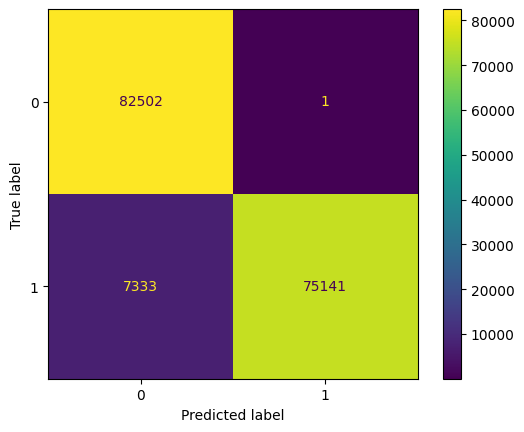

In [85]:
rf_model = RandomForestClassifier().fit(x_train, y_train)  # Membuat model Random Forest dan melatihnya menggunakan data training

predictions = rf_model.predict(x_test)  # Melakukan prediksi menggunakan data testing

# Menampilkan classification report untuk mengevaluasi performa model
print(classification_report(y_test, predictions))

# Menampilkan confusion matrix untuk mengevaluasi performa model
confusionmatrix(predictions, y_test)



> Dari hasil running tersebut, dapat disimpulkan bahwa model Random Forest yang dilatih menggunakan data training memiliki performa yang sangat baik dalam memprediksi label pada data testing. Hal ini ditunjukkan oleh tingkat akurasi yang tinggi, yaitu sebesar 96%. Selain itu, nilai precision, recall, dan f1-score juga sangat tinggi untuk kedua kelas, yaitu sekitar 96%. Dengan demikian, model ini dapat dianggap memiliki kinerja yang sangat baik dalam mempelajari pola dari data training dan memprediksi label dengan akurat pada data testing.



              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    192458
         1.0       1.00      1.00      1.00    192487

    accuracy                           1.00    384945
   macro avg       1.00      1.00      1.00    384945
weighted avg       1.00      1.00      1.00    384945



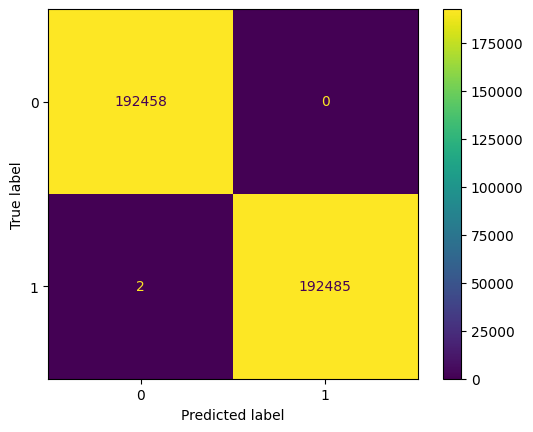

In [86]:
predictions = rf_model.predict(x_train)  # Melakukan prediksi menggunakan data training

# Menampilkan classification report untuk data training
print(classification_report(y_train, predictions))

# Menampilkan confusion matrix untuk data training
confusionmatrix(predictions, y_train)



> Dari hasil running tersebut, dapat disimpulkan bahwa model Random Forest yang dilatih menggunakan data training mampu memprediksi label dengan sempurna. Tingkat akurasi sebesar 100% menunjukkan bahwa model mampu memprediksi semua label dengan benar tanpa adanya kesalahan. Hal ini didukung oleh nilai precision, recall, dan f1-score yang sempurna (1.00) untuk kedua kelas. Dengan demikian, model ini sangat efektif dalam mempelajari pola dari data training dan melakukan prediksi dengan sangat baik.



# **DECISION TREE**

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91     82503
         1.0       0.90      0.92      0.91     82474

    accuracy                           0.91    164977
   macro avg       0.91      0.91      0.91    164977
weighted avg       0.91      0.91      0.91    164977



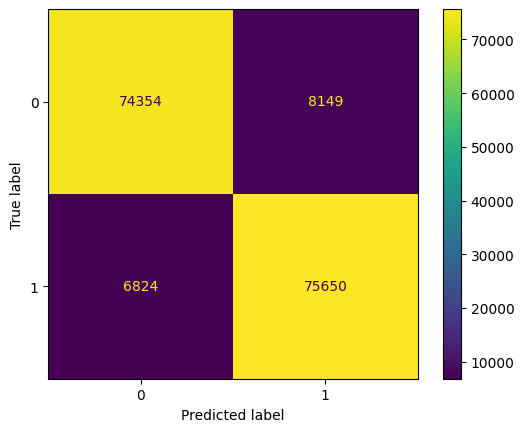

In [87]:
# Membuat objek model Decision Tree dan melatihnya menggunakan data training
dt_model = DecisionTreeClassifier().fit(x_train, y_train)

# Melakukan prediksi menggunakan data testing
predictions = dt_model.predict(x_test)

# Menampilkan classification report untuk mengevaluasi performa model
print(classification_report(y_test, predictions))

# Menampilkan confusion matrix untuk mengevaluasi performa model
confusionmatrix(predictions, y_test)



> Dari hasil running tersebut, dapat disimpulkan bahwa model Decision Tree yang dilatih menggunakan data training memiliki performa yang baik dalam memprediksi label pada data testing. Tingkat akurasi sebesar 91% menunjukkan bahwa model memiliki kemampuan yang tinggi dalam memprediksi label dengan benar. Hal ini didukung oleh nilai precision, recall, dan f1-score yang tinggi dan seimbang untuk kedua kelas, yaitu sekitar 91%. Dengan demikian, model ini dapat dianggap sebagai model yang cukup baik dalam mempelajari pola dari data training.



              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    192458
         1.0       1.00      1.00      1.00    192487

    accuracy                           1.00    384945
   macro avg       1.00      1.00      1.00    384945
weighted avg       1.00      1.00      1.00    384945



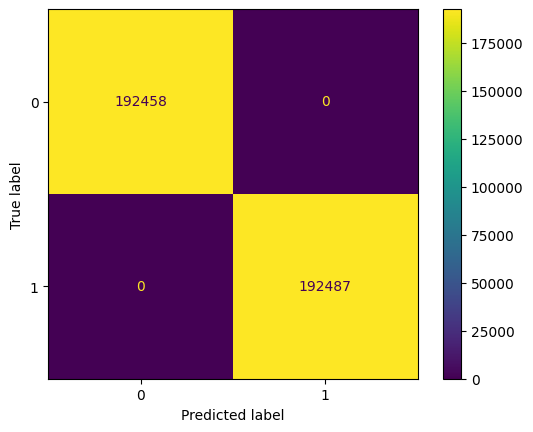

In [88]:
predictions = dt_model.predict(x_train)  # Melakukan prediksi menggunakan data training

# Menampilkan classification report untuk data training
print(classification_report(y_train, predictions))

# Menampilkan confusion matrix untuk data training
confusionmatrix(predictions, y_train)



> Dari empat model tersebut, Random Forest menonjol sebagai yang terbaik karena memiliki tingkat akurasi, presisi, dan recall yang lebih tinggi dibandingkan dengan model lainnya.

> Dari perbandingan akurasi dan prediksi model yang paling baik adalah Random Forest. Meskipun XGBoost memiliki akurasi yang tinggi (95%), Random Forest memiliki akurasi yang sama (96%) tetapi memiliki prediksi yang lebih baik (100%), menunjukkan kemampuan yang lebih unggul dalam mengklasifikasikan data.

> Decision Tree memiliki akurasi 91% dan prediksi sempurna (100%), namun lebih rendah dari XGBoost dan Random Forest yang memiliki akurasi lebih tinggi. Meskipun prediksinya sempurna, akurasi yang rendah menandakan bahwa model tersebut mungkin tidak dapat mempelajari pola yang kompleks dengan baik seperti XGBoost dan Random Forest. Akurasi yang lebih rendah membuatnya kurang unggul dibandingkan dengan XGBoost dan Random Forest.







# **PREDICTION (Prediksi)**

In [89]:
#Membaca file CSV yang terletak di jalur dan memuatnya ke dalam sebuah DataFrame dengan menggunakan library Pandas
df_test = pd.read_csv('/content/drive/MyDrive/Home Credit Indonesia/application_test.csv')

In [90]:
# Mengganti nilai 'XNA' dalam kolom 'CODE_GENDER' dengan mode dari kolom tersebut
df_test['CODE_GENDER'] = df_test['CODE_GENDER'].replace(['XNA'], df_test['CODE_GENDER'].mode()[0])

# Mengganti nilai 'XNA' dalam kolom 'ORGANIZATION_TYPE' dengan mode dari kolom tersebut
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(['XNA'], df_test['ORGANIZATION_TYPE'].mode()[0])

# Membuat list 'Marital_status' untuk menyimpan status perkawinan berdasarkan nilai dari kolom 'NAME_FAMILY_STATUS'
# Jika nilai 'NAME_FAMILY_STATUS' adalah 'Married' atau 'Civil marriage', maka 'Married' ditambahkan ke dalam list, jika tidak 'Unmarried' ditambahkan
Marital_status = []
married = ['Married', 'Civil marriage']

for i in df_test.NAME_FAMILY_STATUS:
    if i in married:
        Marital_status.append('Married')
    else:
        Marital_status.append('Unmarried')

# Menambahkan kolom baru 'Marital_status' ke DataFrame dan menghapus kolom 'NAME_FAMILY_STATUS'
df_test['Marital_status'] = Marital_status
df_test.drop(columns= 'NAME_FAMILY_STATUS', inplace=True)

# Menghitung umur pelanggan dari kolom 'DAYS_BIRTH' dan menyimpannya dalam kolom 'Age'
df_test['Age'] = np.floor(df_test['DAYS_BIRTH'] / -365).astype(int)

# Menghapus kolom 'DAYS_BIRTH' dari DataFrame karena informasi tersebut sudah tidak diperlukan lagi
df_test.drop(columns= 'DAYS_BIRTH', inplace=True)

In [91]:
# Menghitung jumlah data yang bernilai null untuk setiap kolom dalam DataFrame 'df_test' dan menyimpannya dalam DataFrame 'count_nv'
count_nv = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Data']).reset_index()

# Menghitung persentase data null untuk setiap kolom dan menyimpannya dalam kolom 'Percentage' dalam DataFrame 'count_nv'
count_nv['Percentage'] = (count_nv['Total Null Data'] / len(df)) * 100

# Memfilter kolom-kolom yang memiliki persentase data null lebih dari 0 dan menyimpannya dalam DataFrame 'still_null', kemudian diurutkan berdasarkan persentase secara menurun
still_null = count_nv[count_nv['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

In [92]:
# Mengambil nama-nama kolom yang memiliki data null dan menyimpannya dalam variabel 'a'
a = list(still_null['index'])

# Iterasi melalui setiap kolom yang memiliki data null
for i in a:
    # Mengambil data dari kolom tersebut
    data = df_test[i]
    # Mendapatkan tipe data dari kolom
    types = str(data.dtype)
    # Jika tipe data adalah 'object' (string), mengisi data null dengan modus
    if types == 'object':
        df_test[i].fillna(df_test[i].mode()[0], inplace=True)
    # Jika tipe data bukan 'object' (numerik), mengisi data null dengan median
    else:
        df_test[i].fillna(df_test[i].median(), inplace=True)

In [93]:
# Mengambil subset DataFrame yang hanya berisi kolom-kolom numerik
num = df_test[num_a]

In [94]:
# Normalisasi kolom numerik dengan mengurangi mean dan membagi dengan standar deviasi
num = (num - num_mean) / num_std
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,-0.589198,-0.141492,-0.074799,-0.451269,-0.238934,-0.147217,-0.471630,-0.045538,1.444048,-0.131831,...,-0.588676,-0.275683,-0.938725,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.706463
1,-0.589198,-0.292491,-0.934414,-0.671615,-0.969925,1.077392,-0.486707,-1.164490,0.906640,-0.131831,...,-0.588676,-0.275683,1.164645,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.691001,0.456336
2,-0.589198,0.141631,0.159868,2.947791,0.248394,-0.129074,-0.486630,0.803313,-0.339140,-0.131831,...,-0.588676,-0.275683,0.129884,-0.07111,-0.058754,-0.155798,-0.270044,1.032087,1.257036,0.873213
3,2.528453,0.613502,2.424807,1.514138,2.806865,0.397937,-0.468368,0.852911,-0.806307,2.246432,...,-0.588676,-0.275683,-1.017299,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.691001,-0.460793
4,0.969627,0.047256,0.066055,0.343410,0.236211,-0.784603,-0.470658,0.286066,-0.842090,1.057301,...,-0.588676,-0.275683,0.172193,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.124965,-0.710920


In [95]:
# Memilih kolom numerik dari DataFrame
num_1 = df_test[num_b]

# Menghapus indeks yang terduplikat dan memperbarui DataFrame
num_1 = num_1.loc[~num_1.index.duplicated(keep='first')]

# Menggabungkan DataFrame num dengan DataFrame num_1
num = pd.concat([num, num_1], axis=1)
num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,-0.589198,-0.141492,-0.074799,-0.451269,-0.238934,-0.147217,-0.471630,-0.045538,1.444048,-0.131831,...,0,1,0,1,0,0,0,0,0,0
1,-0.589198,-0.292491,-0.934414,-0.671615,-0.969925,1.077392,-0.486707,-1.164490,0.906640,-0.131831,...,0,1,0,0,0,0,0,0,0,0
2,-0.589198,0.141631,0.159868,2.947791,0.248394,-0.129074,-0.486630,0.803313,-0.339140,-0.131831,...,0,1,0,0,0,0,0,0,0,0
3,2.528453,0.613502,2.424807,1.514138,2.806865,0.397937,-0.468368,0.852911,-0.806307,2.246432,...,0,1,1,0,0,0,0,0,0,0
4,0.969627,0.047256,0.066055,0.343410,0.236211,-0.784603,-0.470658,0.286066,-0.842090,1.057301,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,-0.589198,-0.198116,-0.462932,-0.664467,-0.726261,-1.362140,-0.491639,-1.157688,-0.270224,-1.320962,...,1,1,1,0,0,0,0,0,0,0
48740,2.528453,-0.047118,0.058386,0.332532,-0.117102,1.077392,-0.463317,0.565238,-0.007815,2.246432,...,0,1,0,0,0,0,0,0,1,1
48741,0.969627,0.141631,-0.705290,0.422038,-0.604429,0.397937,-0.476618,0.659901,0.985495,1.057301,...,0,1,1,0,0,0,0,0,0,0
48742,-0.589198,0.236005,-0.369923,-0.135821,-0.238934,-0.147217,-0.474462,1.005676,1.078266,-0.131831,...,1,1,1,0,0,1,1,0,1,1


In [96]:
# Memilih kolom-kolom dengan tipe data objek dari DataFrame
obj = df_test.select_dtypes(include='object')

# Iterasi melalui setiap kolom objek
for cat in obj_1:
    # Mengonversi variabel kategori menjadi one-hot encoding
    onehots = pd.get_dummies(obj[cat], prefix=cat)
    # Menggabungkan hasil one-hot encoding ke dalam DataFrame obj
    obj = obj.join(onehots)

# Menghapus kolom-kolom yang sudah diubah menjadi one-hot encoding
obj = obj.drop(columns=obj_1)

In [97]:
# Membuat objek label_encoder untuk melakukan encoding label
label_encoder = preprocessing.LabelEncoder()

# Melakukan encoding pada kolom-kolom yang merupakan variabel kategori
for cat in obj_2:
    obj[cat] = label_encoder.fit_transform(obj[cat])

# Mengembalikan DataFrame obj yang telah diubah
obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,Marital_status,NAME_TYPE_SUITE_Children,...,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University
0,0,0,0,1,reg oper account,block of flats,"Stone, brick",No,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0,0,0,1,reg oper account,block of flats,Panel,No,1,0,...,0,0,0,0,0,0,0,0,0,0
48740,0,0,0,0,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,1,0,0,0,0,0
48741,0,0,1,1,reg oper account,block of flats,"Stone, brick",No,0,0,...,0,0,0,0,0,0,0,0,0,0
48742,0,1,0,0,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# Menggabungkan DataFrame num dan obj menjadi satu DataFrame baru, df_test
df_test = pd.concat([num, obj], axis=1)

In [99]:
# Mengambil set kolom dari DataFrame df
train = set(df.columns)

In [100]:
# Menghapus kolom 'TARGET' dari set train
train.remove('TARGET')

In [101]:
# Mendapatkan kolom yang ada di data pelatihan tetapi tidak ada di data pengujian
not_in_test = list(train - set(df_test.columns))

In [102]:
# Mengisi kolom yang ada di data pelatihan tetapi tidak ada di data pengujian dengan nilai 0
df_test[not_in_test] = 0

In [103]:
# Mengatur kolom data pengujian agar sesuai dengan kolom data pelatihan (tanpa kolom 'TARGET')
column_train = list(df.columns)
column_train.remove('TARGET')
df_test = df_test[column_train]

In [104]:
# Melakukan prediksi menggunakan model Random Forest
predictions = rf_model.predict(df_test)

In [105]:
df_test['TARGET'] = predictions

In [106]:
# Menghitung jumlah nilai dalam kolom target
df_test['TARGET'].value_counts()

0.0    48744
Name: TARGET, dtype: int64



> Dari hasil tersebut dapat disimpulkan bahwa dalam kolom target ('TARGET'), terdapat 48.744 entri dengan nilai 0.0. Hal ini menunjukkan bahwa mayoritas data dalam dataset memiliki nilai target yang sama, yaitu 0.0. Dalam konteks data klasifikasi, seperti yang diasumsikan dari kolom 'TARGET', nilai 0.0 biasanya menandakan kategori atau label negatif atau "tidak memiliki masalah". Jadi, dalam konteks ini, nilai 0.0 mungkin mengindikasikan bahwa pelanggan atau sampel yang bersangkutan tidak memiliki masalah atau risiko yang relevan dengan target yang sedang diprediksi.



In [111]:
# Menulis konten ke file README.md
with open('README.md', 'w') as f:
    f.write(content)

# Mengunduh file README.md
files.download('README.md')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>